# Sentinel-2 Imagery Tutorial

## Overview

The Sentinel-2 Imagery, obtained from the [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2), provides high-resolution satellite images for monitoring the growth of field crops across the United States (U.S.) continent. It offers 224x224 RGB satellite images, with a spatial resolution of 9x9 km, and a revisit frequency of 14 days. Specifically, we utilize [Sentinel Hub Processing API](https://www.sentinel-hub.com/) to acquire satellite images from the Sentinel-2 mission at a processing level of Sentinel-2 L1C, with a maximum allowable cloud coverage of 20% and three spectral bands, i.e., B02, B08, and B11, with resulting satellite images covering 2291 U.S. counties for 6 years (2017-2022).




## Sample Grid Data

In the Sentienl-2 imagery, the geographic boundary of one U.S. county is partitioned into multiple high-resolution grids (i.e., 9x9 km) for precise agricultural monitoring. The following figures illustrate sample grid data from the Sentinel-2 Imagery under four different revisit dates.

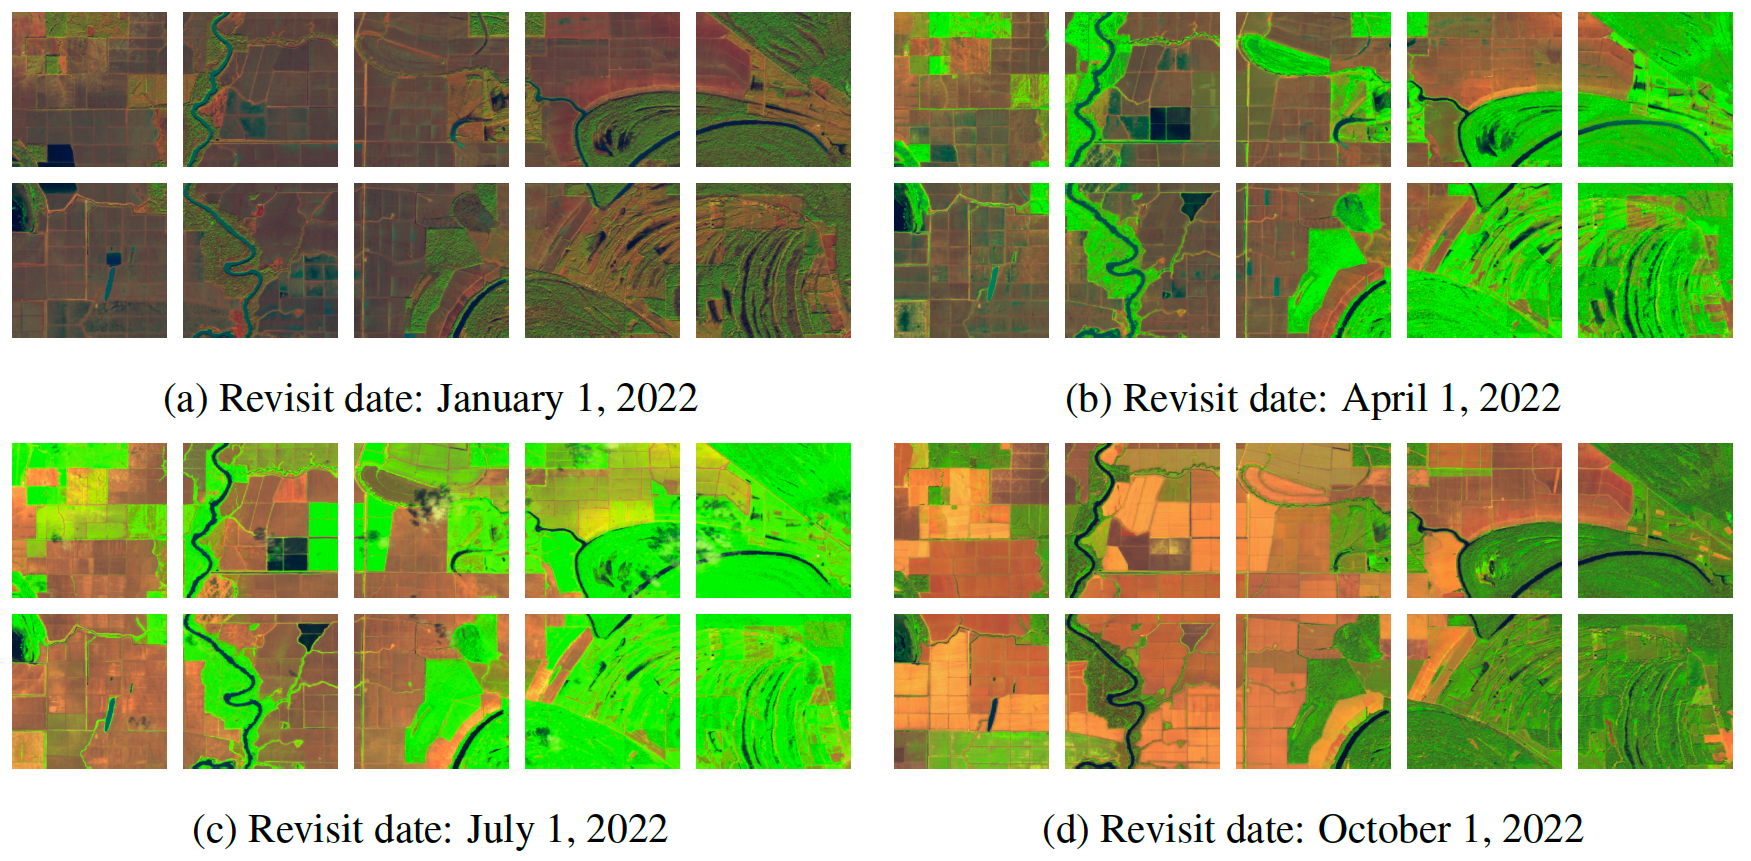

## Data Files
The directory structure is under the following format:
- `CropNet/Sentinel/data/AG/<year>/<state abbreviation>/<file_name>`
- e.g., CropNet/Sentinel/data/AG/2022/AL/Agriculture_01_AL_2022-01-01_2022-03-31.h5

The file name is formatted as below:
- `Agriculture_<state FIPS>_<state abbreviation>_<year>-<start month>-<start day>_<year>-<end month>-<end day>.h5`
- e.g., Agriculture_01_AL_2022-01-01_2022-03-31.h5

## Data Format

Except for satellite images, the Sentinel-2 Imagery also provides valuable information, e.g., the revisit date, the pair of latitude and longitude, etc., to assist researchers in achieving spatial and temporal alignment. In particular, satellite images, along with their description, are saved in the HDF5 file under the following hierarchical structure:

* `FIPS Code` - the FIPS code of the county being represented, e.g. "01001"
     + `date` - the revisit date for satellite images, e.g., "2022-01-01"
      - `data` - a list of satellite images for one county gridded at 9x9km
            - `index: [0]` - the image data for the first grid, i.e., an image with 224x224x3 dimensions
            - `index: [1]` - the image data for the second grid
            - `etc.`

      - `state` - the state name for the above satellite images, e.g., "ALABAMA"
            - `index: [0]` - the state name for all the grids
      - `county` - the county name for the above satellite images, e.g., "AUTAUGA"
            - `index: [0]` - the county name for all the grids
      - `coordinates` - the coordinate information for girds
            - `index: [0]` - the coordinate information for the first grid
                 - `lower left corner lat` (index: [0][0][0]) - the latitude of the lower left corner
                 - `lower left corner lon` (index: [0][0][1]) - the longitude of the lower left corner
                 - `upper right corner lat` (index: [0][1][0]) - the latitude of the upper right corner
                 - `upper right corner lon` (index: [0][1][1]) - the longitude of the upper right corner
            - `etc.`

## Accessing Sentinel Dataset Data
1. Go to the Google Drive [here](https://drive.google.com/drive/folders/1Js98GAxf1LeAUTxP1JMZZIrKvyJStDgz) and download `Sentinel-2 Imagery.zip`
2. Extract the zip file and move it to an appropriate directory, e.g., /mnt/data/CropNet
3. To access the Sentinel data, change the `base_path` below to the directory where you stored the Sentinel data
4. Change the `file_path` below to the particular path you want to visualize

In [9]:
import os
import pandas as pd
import numpy as np
import plotly.figure_factory as ff

# base path for where the Sentinel information has been stored
base_path = "/content/drive/MyDrive/CropNet_Tutorials/input/Sentinel/data/"
# file path for accessing a particular h5 file
file_path = "AG/2022/DE/Agriculture_10_DE_2022-07-01_2022-09-30.h5"

## Examples for the Sentinel-2 Imagery

### Example 1: Visualizing Geographic Distribution of the Sentinel-2 Imagery
1. Go to where you stored the CropNet GitHub clone
2. Copy the path to the `input` folder you see
3. Save that path to `input_path` below for use in plotting

In [2]:
# path to the input folder on GitHub (change to yours)
input_path = "/content/drive/MyDrive/CropNet_Tutorials/input/"

In [3]:
!pip install plotly-geo==1.0.0
!pip install geopandas==0.8.1
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
def get_fips(input_path):
    """Function to get an array of all the fips codes used by the Sentinel dataset

    Parameters
    ----------
    input_path: (String) path to the input folder on the CropNet GitHub

    Returns
    ----------
    (String array) an array of fips codes that are used by the Sentinel dataset
    """
    # get the url to the USDA_counties.csv
    url = input_path + 'USDA/stats/USDA_counties.csv'

    # read the csv file into a pandas DataFrame
    df_relevant_fips = pd.read_csv(url)

    # get the state fips into an array
    states_fips = np.asarray(df_relevant_fips['state_ansi'].values)
    states_fips = [int(val) for val in states_fips]

    # make sure the state fips have two digits
    for i in range(len(states_fips)):
        states_fips[i] = str(states_fips[i]).zfill(2)

    # get the county fips into an array
    counties_fips = np.asarray(df_relevant_fips['county_ansi'].values)
    counties_fips = [int(val) for val in counties_fips]

    # make sure the county fips have three digits
    for i in range(len(counties_fips)):
        counties_fips[i] = str(counties_fips[i]).zfill(3)

    # combine the state and county fips into a final array
    fips = []
    for i in range(len(states_fips)):
        fips.append(states_fips[i] + counties_fips[i])

    return fips

In [6]:
# get all the fips codes used by the Sentinel dataset
fips = get_fips(input_path)

# make an array of equivalent length to the fips array containing 'data'
values = []
for i in range(len(fips)):
    values.append('data')

# plot the map
fig = ff.create_choropleth(fips=fips, values=values,
                          state_outline={'color': 'rgb(0,0,0)', 'width': 1},
                          county_outline={'color': 'rgb(255,255,255)', 'width': 0.25},
                          title='Geographic Distribution of the Sentinel-2 Imagery',
                          show_state_data=True, simplify_county=0, simplify_state=0,
                          colorscale=["#FF6347"])
# don't show the legend
fig.update_layout(showlegend=False)
fig.layout.template = None

# show the figure
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Example 2: Extracting Data from the h5 File

In [10]:
from datetime import timedelta, date
import h5py
from matplotlib import pyplot as plt
import PIL.Image

In [12]:
def display_sample_image(base_path, h5_file_path, FIPS, date, grid_num):
    """Function to return grid image based on a provided h5 file and parameters

    Parameters
    ----------
    base_path: (String) path to where the Sentinel data was downloaded
    h5_file_path: (String) path to the particular h5 file that has images to display
    FIPS: (String) the FIPS code of the county you want to represent
    date: (String) the date that you want images from (Example: "2021-04-01")
    grid_num: (integer) the grid number you want to display

    Returns
    ----------
    None
    """
    # read the h5 file
    h5_data = h5py.File(base_path + h5_file_path, 'r')

    # get the particular county information
    FIPS_data = h5_data[FIPS]

    # get the particular date information
    date_data = FIPS_data[date]

    # print the state of the grid
    state = date_data["state"][0].decode()
    print("State of the Grid:", state)
    print()

    # print the county of the grid
    county = date_data["county"][0].decode()
    print("County of the Grid:", county)
    print()

    # print the coordinates of the particular grid
    coordinates = date_data["coordinates"][grid_num]
    print("Coordinates of the grid:")
    print("lower left corner lat:", round(coordinates[0][0], 2))
    print("lower left corner lon:", round(coordinates[0][1], 2))
    print("upper right corner lat:", round(coordinates[1][0], 2))
    print("upper right corner lon:", round(coordinates[1][1], 2))

    # display the image of the chosen grid
    image_data = date_data["data"][grid_num]

    # show the image
    plt.imshow(image_data)
    plt.show()

State of the Grid: DELAWARE

County of the Grid: SUSSEX

Coordinates of the grid:
lower left corner lat: 38.86
lower left corner lon: -75.34
upper right corner lat: 38.96
upper right corner lon: -75.24


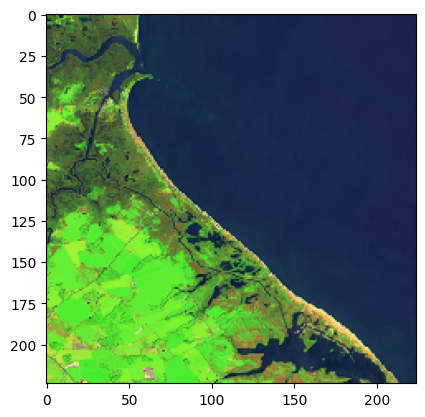

In [40]:
display_sample_image(base_path, file_path, "10005", "2022-08-15", 2)